# Homogenising the 1880 to 2021 dataset
This section will purely focus on the 1880 to 2021 dataset homogenisation as it has already been completed to an extent except a small section.

The data to download is firstly the ACORN-SAT Tmax/Tmin which is our base period that we will be using to bring all the data together, this is based at the location of the Perth Airport.

The second is the Perth Regional Office Tmax/Tmin dataset which is from 1897 to 1992, this is also quality chekced by the BOM and is easily accessable to the public.

The third is the Perth Gardens 1880 to 1900 Tmax/Tmn dataset which is produced by Joelle Gergis group is already a homogenisation to the Perth Regional Office.

Another point to note is that there is daylight savings therefore the times need to be adjusted which has already been completed.

In [107]:
from bisect import bisect_left
import sys
sys.path.append(r"C:\Users\jarra\Desktop\Masters\Heatwave_Project")
import pandas as pd
import PT13_Functions_For_Masters_New_Test as HW_Func
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau


import scipy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")
#RMSE 
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime
import seaborn as sns
np.random.default_rng(seed=None)

Generator(PCG64) at 0x26AB6CD39E0

### PERTH REGIONAL OFFICE 1897 TO 1992

In [108]:
## Perth Regional Office Daily Extreme Dataset
#Load PRO in
#BOM PERTH REGIONAL OFFICE
MaxT_PRO = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\IDCJAC0010_009034_1800_Data.csv")
MinT_PRO = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\IDCJAC0011_009034_1800_Data.csv")

#Clean The data
MaxT_PRO['Datetime']= pd.to_datetime(MaxT_PRO[['Year', 'Month', 'Day']])
MinT_PRO['Datetime']= pd.to_datetime(MinT_PRO[['Year', 'Month', 'Day']])

#Delete irrelevent columns
del MaxT_PRO['Product code']
del MaxT_PRO['Bureau of Meteorology station number']
del MaxT_PRO['Year']
del MaxT_PRO['Month']
del MaxT_PRO['Day']
del MaxT_PRO['Days of accumulation of maximum temperature']
del MaxT_PRO['Quality']
del MinT_PRO['Product code']
del MinT_PRO['Bureau of Meteorology station number']
del MinT_PRO['Year']
del MinT_PRO['Month']
del MinT_PRO['Day']
del MinT_PRO['Days of accumulation of minimum temperature']
del MinT_PRO['Quality']

#Change the column name to date
MaxT_PRO= MaxT_PRO.rename(columns={'Datetime':'date'})
MinT_PRO= MinT_PRO.rename(columns={'Datetime':'date'})


#Change the column names
MaxT_PRO= MaxT_PRO.rename(columns={'Maximum temperature (Degree C)':'PRO Max'})
MinT_PRO= MinT_PRO.rename(columns={'Minimum temperature (Degree C)':'PRO Min'})

#Now concat it
MaxT_PRO= MaxT_PRO.set_index('date')
MinT_PRO= MinT_PRO.set_index('date')

PRO_DE = pd.merge(left = MaxT_PRO,right  =MinT_PRO,left_index=True,right_index=True  )
PRO_DE

,PRO Max,PRO Min
date,,
1897-01-01,30.6,19.4
1897-01-02,29.4,17.8
1897-01-03,27.8,18.3
1897-01-04,31.7,14.4
1897-01-05,36.7,16.1
...,...,...
1992-04-25,29.6,15.7
1992-04-26,30.0,19.5
1992-04-27,22.4,15.7


## ACORN-SAT 1910 - 2021

In [109]:
#Max Temp, (drop(0) has dropped the 0th index, so it starts at 1)
MaxT_Perth = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\tmax.009021.daily.csv").drop(0)
#Min Temp
MinT_Perth = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\tmin.009021.daily.csv").drop(0)

Maximum = pd.Series(MaxT_Perth['maximum temperature (degC)'], name="Max")
Minimum = pd.Series(MinT_Perth['minimum temperature (degC)'],name="Min")

#The Daily Max Min Ave Data
ACORN_SAT = pd.concat([MaxT_Perth['date'],Maximum,Minimum],axis=1)
ACORN_SAT['date'] = pd.to_datetime(ACORN_SAT['date'],format="%d/%m/%Y")
ACORN_SAT = ACORN_SAT.set_index('date')



## Perth Gardens Corrected 1880-1901

<AxesSubplot:xlabel='date'>

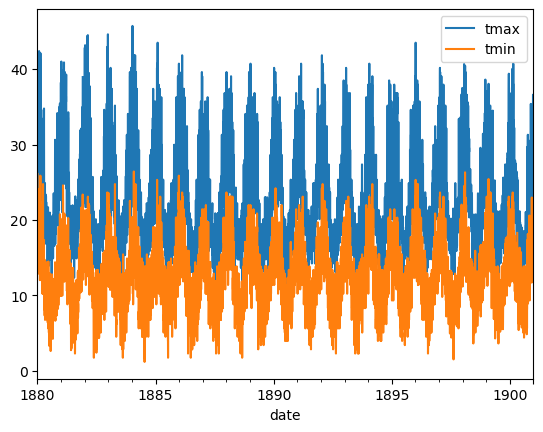

In [110]:
P_Gardens_Corr = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\perthgardens_daily_corrected_1880-1900.csv")



#Now we need to go back in time and minus 200 years off the date
#Convert To Datetime


P_Gardens_Corr['time'] = pd.to_datetime(P_Gardens_Corr['time'],format="%d/%m/%Y")
#print(P_Gardens_Corr)
#P_Gardens_Corr

#Split the Year up

P_Gardens_Corr = HW_Func.Date_Splitter(P_Gardens_Corr,'time',single= True)
P_Gardens_Corr['year'] = P_Gardens_Corr['year']-200

P_Gardens_Corr['date'] = pd.to_datetime(P_Gardens_Corr[['year', 'month', 'day']])
P_Gardens_Corr


del P_Gardens_Corr['time']
del P_Gardens_Corr['year']
del P_Gardens_Corr['month']
del P_Gardens_Corr['day']


P_Gardens_Corr = P_Gardens_Corr.set_index('date')
P_Gardens_Corr.plot()

## Plot the data

<AxesSubplot:xlabel='date'>

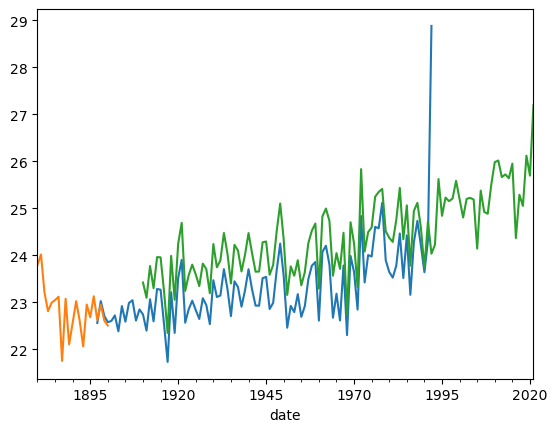

In [111]:
PRO_DE['PRO Max'].resample('Y').mean().plot()
P_Gardens_Corr['tmax'].resample('Y').mean().plot()
ACORN_SAT['Max'].resample('Y').mean().plot()

<AxesSubplot:xlabel='date'>

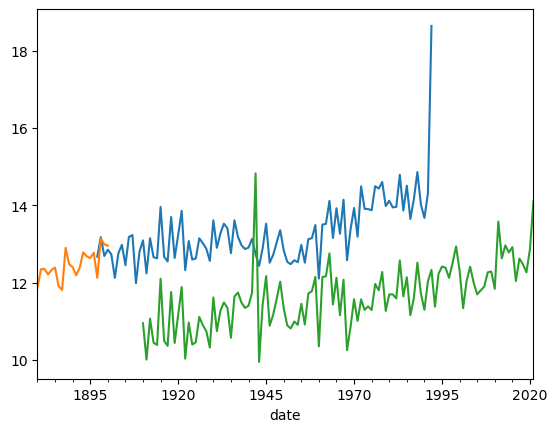

In [112]:
PRO_DE['PRO Min'].resample('Y').mean().plot()
P_Gardens_Corr['tmin'].resample('Y').mean().plot()
ACORN_SAT['Min'].resample('Y').mean().plot()

What we can do now is combine the Perth Regional Office with the corrected Perth Gardens Record due to the already homogenised values to these dataset. This means that the Perth Gardens record is at the same level as the Perth Gardens in terms of the homogenisation.So what we will do is firstly

    -Adjust to DST
    -Combine the PRO with the PG and with the overlap take all the values from the PRO.




In [113]:
PRO_DE.to_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\FOR HOMOGENISATION\Perth_Regional_Office_DE.csv")
P_Gardens_Corr.to_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\FOR HOMOGENISATION\Perth_Gardens_DE.csv")
ACORN_SAT.to_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\FOR HOMOGENISATION\ACORN_SAT_DE.csv")


In [114]:
#Lets reload the data
ACORN_SAT = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\FOR HOMOGENISATION\ACORN_SAT_DE.csv")
PRO = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\FOR HOMOGENISATION\Perth_Regional_Office_DE.csv")
PGS = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\FOR HOMOGENISATION\Perth_Gardens_DE.csv")


In [115]:
ACORN_SAT['date'] = pd.to_datetime(ACORN_SAT['date'])
ACORN_SAT

,date,Max,Min
0,1910-01-01,26.7,16.4
1,1910-02-01,27.0,13.5
2,1910-03-01,27.5,12.0
3,1910-04-01,24.0,13.5
4,1910-05-01,24.8,9.8
...,...,...,...
40719,2021-06-26,20.3,5.8
40720,2021-06-27,15.6,8.7
40721,2021-06-28,19.7,10.5
40722,2021-06-29,18.0,12.5


In [116]:
PRO['date'] = pd.to_datetime(PRO['date'])
PRO

,date,Max,Min
0,1897-01-01,30.6,19.4
1,1897-01-02,29.4,17.8
2,1897-01-03,27.8,18.3
3,1897-01-04,31.7,14.4
4,1897-01-05,36.7,16.1
...,...,...,...
34812,1992-04-25,29.6,15.7
34813,1992-04-26,30.0,19.5
34814,1992-04-27,22.4,15.7
34815,1992-04-28,22.7,15.7


In [117]:
PGS['date'] = pd.to_datetime(PGS['date'])
PGS

,date,Max,Min
0,1880-01-01,38.494444,26.093889
1,1880-01-02,40.383333,23.760556
2,1880-01-03,40.438889,21.427222
3,1880-01-04,40.716667,22.038333
4,1880-01-05,39.050000,19.048269
...,...,...,...
7665,1900-12-27,25.800000,14.300000
7666,1900-12-28,25.709091,16.060000
7667,1900-12-29,25.118182,17.754762
7668,1900-12-30,21.955556,14.136364


In [118]:
#Merge PGS and PRO
#Set index to date
PGS = PGS.set_index('date')
PRO = PRO.set_index('date')


In [127]:
PGS_1880_1896 = PGS.loc['1880-01-01':'1896-12-31']


In [128]:
#concat this onto PRO
PRO_FULL = pd.concat([PGS_1880_1896,PRO])

<AxesSubplot:xlabel='date'>

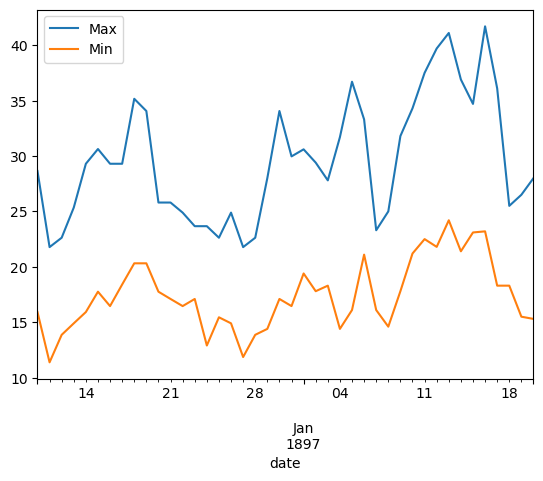

In [131]:
PRO_FULL.loc["1896-12-10":"1897-01-20"].plot()

<AxesSubplot:xlabel='date'>

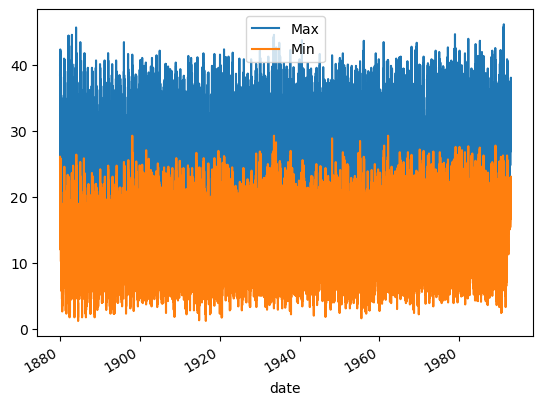

In [133]:
PRO_FULL.plot()

<AxesSubplot:xlabel='date'>

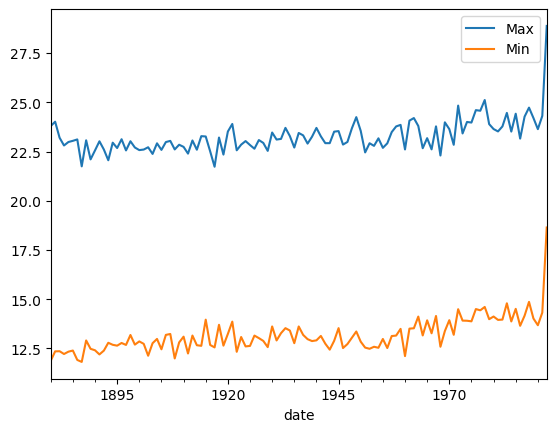

In [134]:
PRO_FULL.resample('Y').mean().plot()

In [135]:
#Save it
#PRO_FULL.to_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\FOR HOMOGENISATION\PRO_1880_1992.csv")


#For the homogenisation using the RHTest we need to get it in its best position we need the data like this:
|Year Month Day Temperature|



In [216]:
#Load it
PRO_Full = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\FOR HOMOGENISATION\PRO_1880_1992.csv")
PRO_Full['date'] = pd.to_datetime(PRO_Full['date'])

PRO_Full

,date,Max,Min
0,1880-01-01,38.494444,26.093889
1,1880-01-02,40.383333,23.760556
2,1880-01-03,40.438889,21.427222
3,1880-01-04,40.716667,22.038333
4,1880-01-05,39.050000,19.048269
...,...,...,...
41022,1992-04-25,29.600000,15.700000
41023,1992-04-26,30.000000,19.500000
41024,1992-04-27,22.400000,15.700000
41025,1992-04-28,22.700000,15.700000


In [217]:
PRO_Full['Year'] =PRO_Full["date"].dt.year
PRO_Full['Month']=PRO_Full["date"].dt.month
PRO_Full['Day']  =PRO_Full["date"].dt.day

In [218]:
PRO_Full

,date,Max,Min,Year,Month,Day
0,1880-01-01,38.494444,26.093889,1880,1,1
1,1880-01-02,40.383333,23.760556,1880,1,2
2,1880-01-03,40.438889,21.427222,1880,1,3
3,1880-01-04,40.716667,22.038333,1880,1,4
4,1880-01-05,39.050000,19.048269,1880,1,5
...,...,...,...,...,...,...
41022,1992-04-25,29.600000,15.700000,1992,4,25
41023,1992-04-26,30.000000,19.500000,1992,4,26
41024,1992-04-27,22.400000,15.700000,1992,4,27
41025,1992-04-28,22.700000,15.700000,1992,4,28


In [219]:
PRO_Full_Max= PRO_Full.copy()
PRO_Full_Min = PRO_Full.copy()
PRO_Full_Min

,date,Max,Min,Year,Month,Day
0,1880-01-01,38.494444,26.093889,1880,1,1
1,1880-01-02,40.383333,23.760556,1880,1,2
2,1880-01-03,40.438889,21.427222,1880,1,3
3,1880-01-04,40.716667,22.038333,1880,1,4
4,1880-01-05,39.050000,19.048269,1880,1,5
...,...,...,...,...,...,...
41022,1992-04-25,29.600000,15.700000,1992,4,25
41023,1992-04-26,30.000000,19.500000,1992,4,26
41024,1992-04-27,22.400000,15.700000,1992,4,27
41025,1992-04-28,22.700000,15.700000,1992,4,28


In [220]:
del PRO_Full_Min['date']
del PRO_Full_Min['Max']
del PRO_Full_Max['date']
del PRO_Full_Max['Min']

In [221]:
PRO_Full_Min

,Min,Year,Month,Day
0,26.093889,1880,1,1
1,23.760556,1880,1,2
2,21.427222,1880,1,3
3,22.038333,1880,1,4
4,19.048269,1880,1,5
...,...,...,...,...
41022,15.700000,1992,4,25
41023,19.500000,1992,4,26
41024,15.700000,1992,4,27
41025,15.700000,1992,4,28


In [222]:
#Now fill NaNs wqith 999.
PRO_Full_Min['Min'] = PRO_Full_Min['Min'].fillna(-999.)
PRO_Full_Max['Max']= PRO_Full_Max['Max'].fillna(-999.)

In [223]:
PRO_Full_Max

,Max,Year,Month,Day
0,38.494444,1880,1,1
1,40.383333,1880,1,2
2,40.438889,1880,1,3
3,40.716667,1880,1,4
4,39.050000,1880,1,5
...,...,...,...,...
41022,29.600000,1992,4,25
41023,30.000000,1992,4,26
41024,22.400000,1992,4,27
41025,22.700000,1992,4,28


In [224]:
PRO_Full_Max['Max'] = PRO_Full_Max['Max'].round(1)

PRO_Full_Min['Min'] = PRO_Full_Min['Min'].round(1)


In [225]:
PRO_Full_Min

,Min,Year,Month,Day
0,26.1,1880,1,1
1,23.8,1880,1,2
2,21.4,1880,1,3
3,22.0,1880,1,4
4,19.0,1880,1,5
...,...,...,...,...
41022,15.7,1992,4,25
41023,19.5,1992,4,26
41024,15.7,1992,4,27
41025,15.7,1992,4,28


In [226]:
PRO_Full_Min = PRO_Full_Min[['Year', 'Month', 'Day', 'Min']]
PRO_Full_Max = PRO_Full_Max[['Year', 'Month', 'Day', 'Max']]

In [227]:
PRO_Full_Max

,Year,Month,Day,Max
0,1880,1,1,38.5
1,1880,1,2,40.4
2,1880,1,3,40.4
3,1880,1,4,40.7
4,1880,1,5,39.0
...,...,...,...,...
41022,1992,4,25,29.6
41023,1992,4,26,30.0
41024,1992,4,27,22.4
41025,1992,4,28,22.7


In [228]:
PRO_Full_Max.to_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\FOR HOMOGENISATION\PRO_Full_Max_Homog.dat", sep='\t', index=False)
PRO_Full_Min.to_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\FOR HOMOGENISATION\PRO_Full_Min_Homog.dat", sep='\t', index=False)

In [233]:
#Now the ACORN-SAT
ACORN_SAT['Year'] =ACORN_SAT["date"].dt.year
ACORN_SAT['Month']=ACORN_SAT["date"].dt.month
ACORN_SAT['Day']  =ACORN_SAT["date"].dt.day

ACORN_SAT_MAX= ACORN_SAT.copy()
ACORN_SAT_MIN = ACORN_SAT.copy()

del ACORN_SAT_MIN['date']
del ACORN_SAT_MIN['Max']
del ACORN_SAT_MAX['date']
del ACORN_SAT_MAX['Min']

ACORN_SAT_MAX['Max'] = ACORN_SAT_MAX['Max'].round(1)

ACORN_SAT_MIN['Min'] = ACORN_SAT_MIN['Min'].round(1)


ACORN_SAT_MIN = ACORN_SAT_MIN[['Year', 'Month', 'Day', 'Min']]
ACORN_SAT_MAX = ACORN_SAT_MAX[['Year', 'Month', 'Day', 'Max']]
ACORN_SAT_MAX
ACORN_SAT_MAX.to_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\FOR HOMOGENISATION\ACORN_SAT_Max_Homog.dat", sep='\t', index=False)
ACORN_SAT_MIN.to_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\FOR HOMOGENISATION\ACORN_SAT_Min_Homog.dat", sep='\t', index=False)

#Now to use R to homogenise

,Year,Month,Day,Max
0,1910,1,1,26.7
1,1910,2,1,27.0
2,1910,3,1,27.5
3,1910,4,1,24.0
4,1910,5,1,24.8
...,...,...,...,...
40719,2021,6,26,20.3
40720,2021,6,27,15.6
40721,2021,6,28,19.7
40722,2021,6,29,18.0


Keeping it in line with previous work on the temperature dataset, we have to go by what Zak balliey has done and also what the precent publsihed paper of Joelle has done to the record. What I aim to acheive in THIS script of my code is the homogneisation of many different datasets onto one single dataset. This single dataset is the longest of them all, and it has already been homognesided previously onto the Perth Aiport in 1963. This dataset is called the ACORN-SATv2 which extends from 1910 to 2021 Jun, and so the aim is to build onto this dataset with the other data I have been recieved over time using statsitcal testing, quantile mathcing technqieuces that have already been inbuilt into the homogneisation function. This means that with the more historical esitmaitons based on my estimated function which will be a quit eof a sigifnciant error/ The homogensation and metadata checking has already been concluded in these datasets, but the part where we can homogenise to 1 dataset is still yet to be comopleted.

There are several goals I aim to achieve in this section. The first is to simply homogenise the 1897 to 1992 perth regioanal office dataset ot the ACORN-SAY which is relativelt straight forward if we follow past research. Then from there, we know that the 1880 to 1900 perth gardens has already been homogensided to the perth regional office by the 3 year overlap from 1897 to 1900 we can just add that together.

From here this means we have a full homogenised dataset from 1880 to 2021. But it does not stop there. We have this historical period from 1830 to 1875, which is from the perth gardens region which shuld closely resemble the 1880 to 1900 dataset in terms of features but not with temperature, this is due to the fact that my daily extreme function overestimates the temperatures between 0.25 to 0.5 depneding on the month in focus. This will need to be accounted for when adjusting to the ACORN-SAT, what we can say is that we lable the 1880-2021 as the P-ACORN-SATv2, which stands for Perth ACORN-SAT Version 2, so in order to mathc th e1830 to 1875 with the 1880 period we need to mean adjust based on another record. WHat i mean is we need to find a record that fills this missing gap from 1875 to 1880 and overlaps with at least 2 or more years either side. This is where the 20 century Reanalysis procut Version 3 will be involved where it will mathc the 30 year mean of each month from 1846 to 1875 of the histroical with the mean of the 20CR, a 20CR mean from 1862 to 1892 to accunt for the midpoint fo the missing data and the 1880 to 1911 monthly means of the P-ACORN-SATv2 and the 20CR. This will hopeuflly then match these means together in a few small adjustments.

In [232]:
ACORN_SAT

,date,Max,Min,Year,Month,Day
0,1910-01-01,26.7,16.4,1910,1,1
1,1910-02-01,27.0,13.5,1910,2,1
2,1910-03-01,27.5,12.0,1910,3,1
3,1910-04-01,24.0,13.5,1910,4,1
4,1910-05-01,24.8,9.8,1910,5,1
...,...,...,...,...,...,...
40719,2021-06-26,20.3,5.8,2021,6,26
40720,2021-06-27,15.6,8.7,2021,6,27
40721,2021-06-28,19.7,10.5,2021,6,28
40722,2021-06-29,18.0,12.5,2021,6,29
